<a href="https://colab.research.google.com/github/rami-fetouh-school/TS_HW/blob/main/HW8_PartB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#mxnet is a prerequisite for gluonts
!pip install mxnet
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from tqdm.autonotebook import tqdm
from pathlib import Path

!pip install gluonts

     |████████████████████████████████| 46.9 MB 1.6 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  # This is added back by InteractiveShellApp.init_path()


     |████████████████████████████████| 2.1 MB 20.5 MB/s 
     |████████████████████████████████| 10.1 MB 41.1 MB/s 


In [3]:
#setup global variables for answerer. Setup toggle for which length to use
single_prediction_length = 28
answer_prediction_length = single_prediction_length #* 2
m5_input_path="/content/drive/MyDrive"
answer=True

if answer:
    prediction_length = answer_prediction_length
else:
    prediction_length = single_prediction_length

In [4]:
#Read the files as dataframes
calendar = pd.read_csv('/content/drive/MyDrive/calendar.csv')
sales_train_validation = pd.read_csv('/content/drive/MyDrive/sales_train_evaluation.csv')
sell_prices = pd.read_csv('/content/drive/MyDrive/sell_prices.csv')

In [5]:
#Include dynamic features
cal_features = calendar.drop(
    ['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1', 'event_name_2', 'd'], 
    axis=1
)
cal_features['event_type_1'] = cal_features['event_type_1'].apply(lambda x: 0 if str(x)=="nan" else 1)
cal_features['event_type_2'] = cal_features['event_type_2'].apply(lambda x: 0 if str(x)=="nan" else 1)

test_cal_features = cal_features.values.T
if answer:
    train_cal_features = test_cal_features[:,:-answer_prediction_length]
else:
    train_cal_features = test_cal_features[:,:-answer_prediction_length-single_prediction_length]
    test_cal_features = test_cal_features[:,:-answer_prediction_length]

test_cal_features_list = [test_cal_features] * len(sales_train_validation)
train_cal_features_list = [train_cal_features] * len(sales_train_validation)

In [6]:
#Static features
state_ids = sales_train_validation["state_id"].astype('category').cat.codes.values
state_ids_un , state_ids_counts = np.unique(state_ids, return_counts=True)

store_ids = sales_train_validation["store_id"].astype('category').cat.codes.values
store_ids_un , store_ids_counts = np.unique(store_ids, return_counts=True)

cat_ids = sales_train_validation["cat_id"].astype('category').cat.codes.values
cat_ids_un , cat_ids_counts = np.unique(cat_ids, return_counts=True)

dept_ids = sales_train_validation["dept_id"].astype('category').cat.codes.values
dept_ids_un , dept_ids_counts = np.unique(dept_ids, return_counts=True)

item_ids = sales_train_validation["item_id"].astype('category').cat.codes.values
item_ids_un , item_ids_counts = np.unique(item_ids, return_counts=True)

stat_cat_list = [item_ids, dept_ids, cat_ids, store_ids, state_ids]
stat_cat = np.concatenate(stat_cat_list)
stat_cat = stat_cat.reshape(len(stat_cat_list), len(item_ids)).T

stat_cat_cardinalities = [len(item_ids_un), len(dept_ids_un), len(cat_ids_un), len(store_ids_un), len(state_ids_un)]

In [7]:
!pip install orjson

#Build train and answer sets
from gluonts.dataset.common import load_datasets, ListDataset
from gluonts.dataset.field_names import FieldName

train_df = sales_train_validation.drop(["id","item_id","dept_id","cat_id","store_id","state_id"], axis=1)
train_target_values = train_df.values

if answer == True:
    test_target_values = [np.append(ts, np.ones(answer_prediction_length) * np.nan) for ts in train_df.values]
else:
    test_target_values = train_target_values.copy()
    train_target_values = [ts[:-single_prediction_length] for ts in train_df.values]

m5_dates = [pd.Timestamp("2011-01-29", freq='1D') for _ in range(len(sales_train_validation))]

train_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start,
        FieldName.FEAT_DYNAMIC_REAL: fdr,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, start, fdr, fsc) in zip(train_target_values,
                                         m5_dates,
                                         train_cal_features_list,
                                         stat_cat)
], freq="D")

test_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start,
        FieldName.FEAT_DYNAMIC_REAL: fdr,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, start, fdr, fsc) in zip(test_target_values,
                                         m5_dates,
                                         test_cal_features_list,
                                         stat_cat)
], freq="D")

     |████████████████████████████████| 249 kB 33.8 MB/s 


In [8]:
#Verify that dataset format is correct/ correct target values as well as dynamic and static features.
next(iter(train_ds))

{'feat_dynamic_real': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'feat_static_cat': array([1437,    3,    1,    0,    0], dtype=int32),
 'source': SourceContext(source='list_data', row=0),
 'start': Timestamp('2011-01-29 00:00:00', freq='D'),
 'target': array([0., 0., 0., ..., 3., 0., 1.], dtype=float32)}

In [9]:
#Define the estimator 
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.mx.trainer import Trainer

estimator = DeepAREstimator(
    prediction_length=prediction_length,
    freq="D",
    distr_output = NegativeBinomialOutput(),
    use_feat_dynamic_real=True,
    use_feat_static_cat=True,
    cardinality=stat_cat_cardinalities,
    trainer=Trainer(
        learning_rate=1e-3,
        epochs= 3, #originally 100
        num_batches_per_epoch=50,
        batch_size=32
    )
)

predictor = estimator.train(train_ds)

100%|██████████| 50/50 [00:05<00:00,  8.94it/s, epoch=3/3, avg_epoch_loss=0.893]


In [10]:
#Generate forecasts
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
    num_samples=100
)

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(test_ds)))
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(test_ds)))

Obtaining time series conditioning values ...


  0%|          | 0/30490 [00:00<?, ?it/s]

Obtaining time series predictions ...


  0%|          | 0/30490 [00:00<?, ?it/s]

In [11]:
#Local performance validation
if answer == False:
    
    from gluonts.evaluation import Evaluator
    
    class M5Evaluator(Evaluator):
        
        def get_metrics_per_ts(self, time_series, forecast):
            successive_diff = np.diff(time_series.values.reshape(len(time_series)))
            successive_diff = successive_diff ** 2
            successive_diff = successive_diff[:-prediction_length]
            denom = np.mean(successive_diff)
            pred_values = forecast.samples.mean(axis=0)
            true_values = time_series.values.reshape(len(time_series))[-prediction_length:]
            num = np.mean((pred_values - true_values)**2)
            rmsse = num / denom
            metrics = super().get_metrics_per_ts(time_series, forecast)
            metrics["RMSSE"] = rmsse
            return metrics
        
        def get_aggregate_metrics(self, metric_per_ts):
            wrmsse = metric_per_ts["RMSSE"].mean()
            agg_metric , _ = super().get_aggregate_metrics(metric_per_ts)
            agg_metric["MRMSSE"] = wrmsse
            return agg_metric, metric_per_ts
        
    
    evaluator = M5Evaluator(quantiles=[0.5, 0.67, 0.95, 0.99])
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    print(json.dumps(agg_metrics, indent=4))

In [12]:
#Convert forecast back to format
if answer == True:
    forecasts_acc = np.zeros((len(forecasts), prediction_length))
    for i in range(len(forecasts)):
        forecasts_acc[i] = np.mean(forecasts[i].samples, axis=0)

Plotting time series predictions ...


  0%|          | 0/5 [00:00<?, ?it/s]

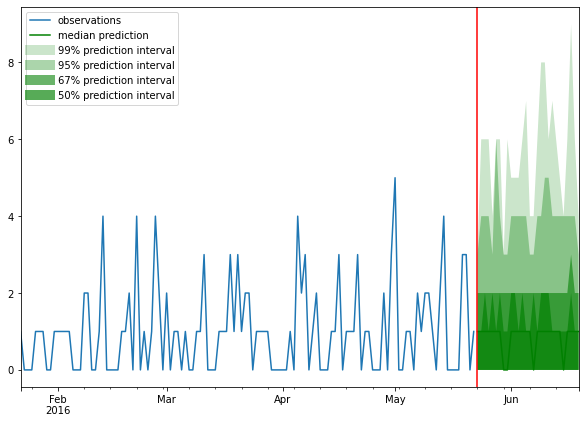

<Figure size 432x288 with 0 Axes>

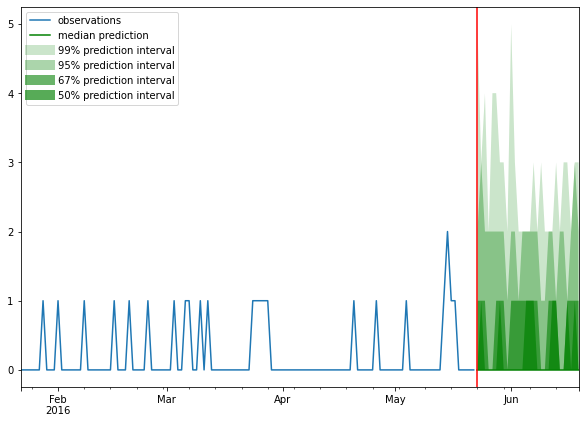

<Figure size 432x288 with 0 Axes>

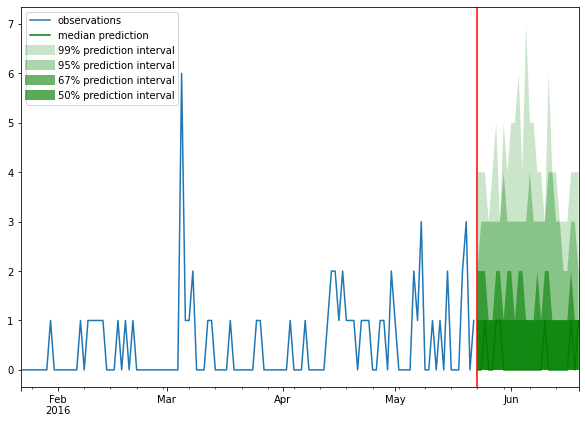

<Figure size 432x288 with 0 Axes>

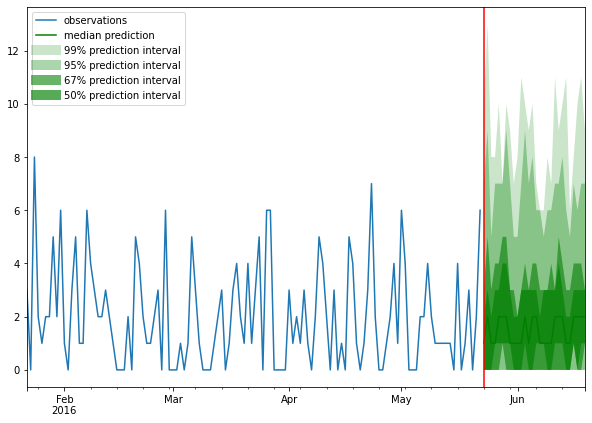

<Figure size 432x288 with 0 Axes>

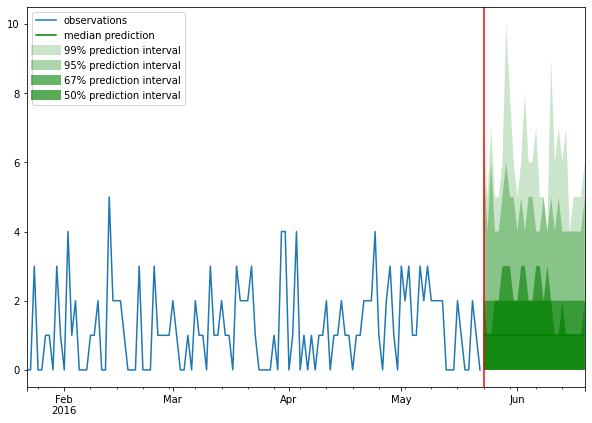

<Figure size 432x288 with 0 Axes>

In [13]:
#Plots

plot_log_path = "./plots/"
directory = os.path.dirname(plot_log_path)
if not os.path.exists(directory):
    os.makedirs(directory)
    
def plot_prob_forecasts(ts_entry, forecast_entry, path, sample_id, inline=True):
    plot_length = 150
    prediction_intervals = (50, 67, 95, 99)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    _, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    ax.axvline(ts_entry.index[-prediction_length], color='r')
    plt.legend(legend, loc="upper left")
    if inline:
        plt.show()
        plt.clf()
    else:
        plt.savefig('{}forecast_{}.pdf'.format(path, sample_id))
        plt.close()

print("Plotting time series predictions ...")
for i in tqdm(range(5)):
    ts_entry = tss[i]
    forecast_entry = forecasts[i]
    plot_prob_forecasts(ts_entry, forecast_entry, plot_log_path, i)